# Twitter Sentiment Analysis

1. Build the model
2. Extract features from Twitter
3. Run the classifier

## Build model

In [40]:
import pandas as pd
import numpy as np
import csv
import nltk
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.externals import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

import pickle
import re
from collections import Counter
from string import punctuation
import tweepy
from tweepy import OAuthHandler
import json
import os



In [41]:
train = pd.read_csv(os.path.join("../..","data","twitter-training-data","train.csv"),encoding = "ISO-8859-1",header=0)

In [42]:
train.head(), train.shape

(   target          id                          date      flag       username  \
 0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
 1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
 2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
 3       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
 4       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   
 
                                                 text  
 0  is upset that he can't update his Facebook by ...  
 1  @Kenichan I dived many times for the ball. Man...  
 2    my whole body feels itchy and like its on fire   
 3  @nationwideclass no, it's not behaving at all....  
 4                      @Kwesidei not the whole crew   , (1048575, 6))

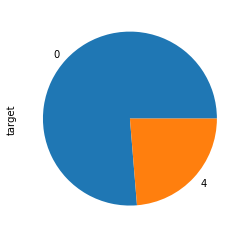

In [48]:
##target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
train["target"].value_counts().plot.pie()

In [44]:
print("No of positives", positives_df.shape)
print("No of negatives",negatives_df.shape)
print("No of neutral", neutral_df.shape)

No of positives (248576, 6)
No of negatives (799999, 6)
No of neutral (0, 6)


In [50]:
test = pd.read_csv(os.path.join("../..","data","twitter-training-data","test.csv"),encoding="ISO-8859-1",header=0)
test.head()

,target,id,date,username,username2,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [63]:
from sklearn.utils import shuffle
train = shuffle(train)

X_train, X_test, y_train, y_test = train_test_split(train['text'][:5000], train['target'][:5000], test_size=0.2,random_state=42, shuffle=True)


In [64]:
print("No of train,", len(X_train),"No of test",len(X_test))

No of train, 4000 No of test 1000


In [66]:
y_train.value_counts()

0    3036
4     964
Name: target, dtype: int64

In [67]:
## Create pipeline for the model
pipeline = Pipeline([
    ('bow', CountVectorizer(strip_accents='ascii',
                            stop_words='english',
                            lowercase=True)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [69]:
## Grid search for parameters.

parameters = {'bow__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'classifier__alpha': (1e-2, 1e-3),
             }


# do 10-fold cross validation for each of the 6 possible combinations of the above params
grid = GridSearchCV(pipeline, cv=10, param_grid=parameters, verbose=1)
grid.fit(X_train,y_train)


Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   10.4s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        s...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'bow__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'classifier__alpha': (0.01, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [70]:
## Save the model
# save best model to current working directory
joblib.dump(grid, "twitter_sentiment.pkl")

['twitter_sentiment.pkl']

In [71]:
# load from file and predict using the best configs found in the CV step
model_NB = joblib.load("twitter_sentiment.pkl" )

# get predictions from best model above
y_preds = model_NB.predict(X_test)


In [73]:
print("Accuracy score",accuracy_score(y_test,y_preds))

Accuracy score 0.778


In [105]:
# get predictions from best model above

# test string
sample_str = "WIN"
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer


analysis = TextBlob(sample_str)

In [106]:
polarity  = analysis.polarity

In [108]:
polarity, sentiment

NameError: name 'sentiment' is not defined